In [159]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

In [180]:
df = pd.read_stata('../dta files/2022.dta')

In [181]:
df['MARITAL'].cat.categories

Index(['-9. No answer', '-7. Refused', '1. Married', '2. Civil partnership',
       '3. Separated from spouse/civil partner (still legally married/still legally in a civil partnership)',
       '4. Divorced from spouse/legally separated from civil partner',
       '5. Widowed/civil partner died',
       '6. Never married/never in a civil partnership'],
      dtype='object')

In [182]:
df[(df['HHADULT']=='2. Two adults') & (df['MARITAL'].isin(['1. Married', '2. Civil partnership']))]

,studyno,version,doi,country,c_sample,c_alphan,v1,v2,v3,v4,...,DATEMO,DATEDY,INTLANG,DWEIGHT_HH,DWEIGHT_TS,DWEIGHT_COM,PSWEIGHT,WEIGHT_COM,MODE,PARTIALS
4,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,40. AT-Austria,40. AT-Austria,AT,1. Strongly agree,5. Strongly disagree,4. Disagree,5. Strongly disagree,...,1. January,5,11. German (deu),0.675291,1. No weighting,0.675291,0.460084,0.530512,"50. CAWI, self-completion, web questionnaire",1. Complete case
6,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,40. AT-Austria,40. AT-Austria,AT,1. Strongly agree,2. Agree,1. Strongly agree,2. Agree,...,1. January,22,11. German (deu),0.675291,1. No weighting,0.675291,0.626578,0.460856,"50. CAWI, self-completion, web questionnaire",1. Complete case
10,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,40. AT-Austria,40. AT-Austria,AT,1. Strongly agree,3. Neither agree nor disagree,3. Neither agree nor disagree,5. Strongly disagree,...,1. January,8,11. German (deu),0.675291,1. No weighting,0.675291,0.975243,0.62049,"50. CAWI, self-completion, web questionnaire",1. Complete case
11,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,40. AT-Austria,40. AT-Austria,AT,1. Strongly agree,4. Disagree,4. Disagree,5. Strongly disagree,...,1. January,9,11. German (deu),0.675291,1. No weighting,0.675291,1.657061,2.119088,"50. CAWI, self-completion, web questionnaire",1. Complete case
18,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,40. AT-Austria,40. AT-Austria,AT,1. Strongly agree,3. Neither agree nor disagree,5. Strongly disagree,4. Disagree,...,1. January,15,11. German (deu),0.675291,1. No weighting,0.675291,0.626578,0.460856,"50. CAWI, self-completion, web questionnaire",1. Complete case
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45715,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,710. ZA-South Africa,710. ZA-South Africa,ZA,2. Agree,3. Neither agree nor disagree,2. Agree,2. Agree,...,2. February,19,65. Sepedi (nso),1.216794,1. No weighting,1.216794,1. No weighting,1.000568,"24. CAPI, interpreter or translator- visuals",1. Complete case
45723,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,710. ZA-South Africa,710. ZA-South Africa,ZA,4. Disagree,3. Neither agree nor disagree,4. Disagree,2. Agree,...,2. February,20,52. Venda (ven),1.82519,1. No weighting,1.82519,1. No weighting,1.806367,"24. CAPI, interpreter or translator- visuals",1. Complete case
45727,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,710. ZA-South Africa,710. ZA-South Africa,ZA,3. Neither agree nor disagree,3. Neither agree nor disagree,2. Agree,4. Disagree,...,2. February,20,65. Sepedi (nso),1.216794,1. No weighting,1.216794,1. No weighting,0.718788,"24. CAPI, interpreter or translator- visuals",1. Complete case
45730,10000. GESIS Study Number ZA10000,2.0.0 (2025-08-22),doi:10.4232/5.ZA10000.2.0.0,710. ZA-South Africa,710. ZA-South Africa,ZA,4. Disagree,2. Agree,2. Agree,2. Agree,...,2. February,20,65. Sepedi (nso),1.216794,1. No weighting,1.216794,1. No weighting,0.920749,"24. CAPI, interpreter or translator- visuals",1. Complete case


### Loading 2002, 2012 dta files

In [183]:
with pd.io.stata.StataReader("../dta files/2012.dta", convert_categoricals=True) as rdr:
    cols = [c for c in rdr.variable_labels().keys() if c not in {"ISCO88", "SPISCO88"}]
    df_2012 = rdr.read(columns=cols)

with pd.io.stata.StataReader("../dta files/2002.dta", convert_categoricals=True) as rdr:
    cols = [c for c in rdr.variable_labels().keys() if c not in ["v241","v247"]]
    df_2002 = rdr.read(columns=cols)


In [184]:
df_2022 = pd.read_stata("../dta files/2022.dta")

In [185]:
df_1988 = pd.read_stata("../dta files/1988.dta")

### Analysis for 2002

Trying to find if males who earn more manage the household income or not in 2002

In [7]:
df_2002[
    (df_2002['v202']=='Marr,liv as mar') & 
    (df_2002["v200"]=='Male') & 
    (df_2002['v43'].isin(['Spouse has higher income', 'Spouse has much higher income']))]["v29"].value_counts(normalize=True) * 100

v29
We pool all the money                   58.233276
Spouse,partner manages money            15.265866
We pool some money                      14.236707
Each keep own money separate             9.262436
I manage all the money                   3.001715
TW:my mother-in-law manage the money     0.000000
Name: proportion, dtype: float64

In [8]:
df_2002[
    (df_2002['v202']=='Marr,liv as mar') & 
    (df_2002["v200"]=='Male') & 
    (df_2002['v43'].isin(['I have a higher income', 'I have much higher income']))]["v29"].value_counts(normalize=True) * 100

v29
We pool all the money                   59.262083
We pool some money                      12.456167
Spouse,partner manages money            12.105504
I manage all the money                   8.583626
Each keep own money separate             7.592621
TW:my mother-in-law manage the money     0.000000
Name: proportion, dtype: float64

Trying to find if females who earn more manage the household income or not in 2002

In [9]:
df_2002[
    (df_2002['v202']=='Marr,liv as mar') & 
    (df_2002["v200"]=='Female') & 
    (df_2002['v43'].isin(['Spouse has higher income', 'Spouse has much higher income']))]["v29"].value_counts(normalize=True) * 100

v29
We pool all the money                   58.953778
We pool some money                      13.230003
I manage all the money                  12.316634
Each keep own money separate             8.843067
Spouse,partner manages money             6.656518
TW:my mother-in-law manage the money     0.000000
Name: proportion, dtype: float64

In [10]:
df_2002[
    (df_2002['v202']=='Marr,liv as mar') & 
    (df_2002["v200"]=='Female') & 
    (df_2002['v43'].isin(['I have a higher income', 'I have much higher income']))]["v29"].value_counts(normalize=True) * 100

v29
We pool all the money                   53.907816
We pool some money                      15.497662
I manage all the money                  14.762859
Each keep own money separate            11.823647
Spouse,partner manages money             4.008016
TW:my mother-in-law manage the money     0.000000
Name: proportion, dtype: float64

### Analysis for 2012

Trying to find if males who earn more manage the household income or not in 2012

In [11]:
df_2012['V50'].cat.categories

Index(['NAP, no partner (3 (AT,BE,CH,CL,ES,IN,IS,KR,NL,NO,PL,SK,US:2,3;AR,BG,CZ,PT:2,3,7;IL:3,7) in PARTLIV;TW:3-6 in MARITAL)',
       'My spouse/ partner has no income', 'I have a much higher income',
       'I have a higher income', 'We have about the same income',
       'My spouse/ partner has a higher income',
       'My spouse/ partner has a much higher income', 'I have no income',
       'TW: Both have no income',
       'Don't know, BG: can't choose, KR: don't know, refused', 'No answer'],
      dtype='object')

In [12]:
temp = df_2012[
    (df_2012['MARITAL']=='Married') & 
    (df_2012["SEX"]=='Male') & 
    (df_2012['V50'].isin(['My spouse/ partner has a higher income', 'My spouse/ partner has a much higher income']))
    ]["V41"].value_counts(normalize=True) * 100
temp[temp > 1]

V41
We pool all money, each take out             53.428742
Partner manages all and gives me my share    16.935003
We pool some money, rest separate            12.880143
We each keep own money separate               9.779368
I manage all and give partner his share       6.320811
Name: proportion, dtype: float64

In [13]:
temp1 = df_2012[
    (df_2012['MARITAL']=='Married') & 
    (df_2012["SEX"]=='Male') & 
    (df_2012['V50'].isin(['I have a higher income', 'I have a much higher income']))
    ]["V41"].value_counts(normalize=True) * 100
temp1[temp1 > 1]

V41
We pool all money, each take out             54.061752
Partner manages all and gives me my share    13.364475
We pool some money, rest separate            11.849151
I manage all and give partner his share      11.347841
We each keep own money separate               8.237439
Name: proportion, dtype: float64

In [14]:
temp3 = df_2012[
    (df_2012['MARITAL']=='Married') & 
    (df_2012["SEX"]=='Male') & 
    (df_2012['V50'].isin(['My spouse/ partner has a higher income', 'My spouse/ partner has a much higher income']))
    & (df_2012['V4']=="IN-India")
    ]["V41"].value_counts(normalize=True) * 100
temp3[temp3 > 1]

V41
We pool all money, each take out             31.460674
Partner manages all and gives me my share    21.348315
We pool some money, rest separate            21.348315
I manage all and give partner his share      14.606742
We each keep own money separate              10.112360
No answer, CA: no answer, refused             1.123596
Name: proportion, dtype: float64

In [15]:
temp4 = df_2012[
    (df_2012['MARITAL']=='Married') & 
    (df_2012["SEX"]=='Male') & 
    (df_2012['V50'].isin(['I have a higher income', 'I have a much higher income']))
    &(df_2012['V4']=='IN-India')
    ]["V41"].value_counts(normalize=True) * 100
temp4[temp4 > 1]

V41
We each keep own money separate              42.0
We pool some money, rest separate            23.5
We pool all money, each take out             15.5
No answer, CA: no answer, refused             6.5
I manage all and give partner his share       5.0
Partner manages all and gives me my share     5.0
Don't know, KR: don't know, refused           2.5
Name: proportion, dtype: float64

In [16]:
temp3 = df_2012[
    (df_2012['MARITAL']=='Married') & 
    (df_2012["SEX"]=='Female') & 
    (df_2012['V50'].isin(['My spouse/ partner has a higher income', 'My spouse/ partner has a much higher income']))
    & (df_2012['V4']=="IN-India")
    ]["V41"].value_counts(normalize=True) * 100
temp3[temp3 > 1]

V41
Partner manages all and gives me my share    62.686567
I manage all and give partner his share      28.358209
We pool all money, each take out              4.477612
We pool some money, rest separate             1.492537
We each keep own money separate               1.492537
No answer, CA: no answer, refused             1.492537
Name: proportion, dtype: float64

In [17]:
temp4 = df_2012[
    (df_2012['MARITAL']=='Married') & 
    (df_2012["SEX"]=='Female') & 
    (df_2012['V50'].isin(['I have a higher income', 'I have a much higher income']))
    &(df_2012['V4']=='IN-India')
    ]["V41"].value_counts(normalize=True) * 100
temp4[temp4 > 1]

V41
We pool some money, rest separate            22.222222
We each keep own money separate              20.634921
No answer, CA: no answer, refused            19.047619
We pool all money, each take out             12.698413
Partner manages all and gives me my share    11.111111
I manage all and give partner his share       9.523810
Don't know, KR: don't know, refused           4.761905
Name: proportion, dtype: float64

In [18]:
df_2012['V4'].value_counts()

V4
CN-China                                  5946
ES-Spain                                  2595
ZA-South Africa                           2547
FR-France                                 2409
BE-Belgium                                2202
TW-Taiwan                                 2072
CZ-Czech Republic                         1804
DE-Germany                                1766
IN-India                                  1660
TR-Turkey                                 1620
AU-Australia                              1612
CL-Chile                                  1564
MX-Mexico                                 1527
RU-Russia                                 1525
NO-Norway                                 1444
DK-Denmark                                1403
KR-Korea (South)                          1396
NL-Netherlands                            1315
US-United States                          1302
CH-Switzerland                            1237
IL-Israel                                 1220
IE-Ireland

In [169]:
import plotly.express as px

scenarios = {
    "spouse_higher": [
        "My spouse/ partner has a higher income",
        "My spouse/ partner has a much higher income",
    ],
    "self_higher": [
        "I have a higher income",
        "I have a much higher income",
    ],
}

frames = []
for scen, inc_vals in scenarios.items():
    subset = df_2012[
        (df_2012["MARITAL"] == "Married")
        & (df_2012["SEX"] == "Male")
        & (df_2012["V50"].isin(inc_vals))
    ]
    grp = (
        subset.groupby("V4")["V41"]
        .value_counts(normalize=True)
        .mul(100)
        .rename("pct")
        .reset_index()
    )
    grp["scenario"] = scen
    frames.append(grp)

fin = pd.concat(frames, ignore_index=True)
fin = fin[fin["pct"] > 1]  # drop ~0% cells if desired
fin.head()


/var/folders/63/xjytlmqx00l531c05ds9f7nc0000gn/T/ipykernel_15018/1670445310.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/63/xjytlmqx00l531c05ds9f7nc0000gn/T/ipykernel_15018/1670445310.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,V4,V41,pct,scenario
0,AR-Argentina,"We pool all money, each take out",50.000000,spouse_higher
1,AR-Argentina,We each keep own money separate,21.428571,spouse_higher
2,AR-Argentina,"We pool some money, rest separate",14.285714,spouse_higher
3,AR-Argentina,"Don't know, KR: don't know, refused",14.285714,spouse_higher
9,AU-Australia,"We pool all money, each take out",52.727273,spouse_higher


In [170]:
import plotly.io as pio
fig1 = px.bar(
    fin[fin["scenario"] == "spouse_higher"],
    x="V4", y="pct", color="V41",
    barmode="stack", title="Spouse earns more (Married men)",
)
pio.renderers.default = "browser"
fig1.show()

fig2 = px.bar(
    fin[fin["scenario"] == "self_higher"],
    x="V4", y="pct", color="V41",
    barmode="stack", title="Respondent earns more (Married men)",
)

fig2.show()


In [171]:
temp4 = df_2012[
    (df_2012['MARITAL']=='Married') & 
    (df_2012["SEX"]=='Female') & 
    (df_2012['V50'].isin(['My spouse/ partner has no income']))
    & (df_2012['V4']=='IN-India')
    ]["V41"].value_counts(normalize=True) * 100
temp4[temp4 > 1]

V41
I manage all and give partner his share      36.363636
Partner manages all and gives me my share    22.727273
We pool some money, rest separate            22.727273
We pool all money, each take out             18.181818
Name: proportion, dtype: float64

In [172]:
df_2012['V41'].cat.categories

Index(['NAP, no partner (3 (AT,BE,CH,CL,ES,IS,KR,NL,NO,PL,SK,US:2,3; AR,BG,CZ,PT:2,3,7;IL:3,7) in PARTLIV;TW:3-6 in MARITAL)',
       'I manage all and give partner his share',
       'Partner manages all and gives me my share',
       'We pool all money, each take out', 'We pool some money, rest separate',
       'We each keep own money separate',
       'TW: My son or my daughter-in-law manages the money',
       'Don't know, KR: don't know, refused',
       'No answer, CA: no answer, refused'],
      dtype='object')

In [173]:
bad = "NAP, no partner (3 (AT,BE,CH,CL,ES,IN,IS,KR,NL,NO,PL,SK,US:2,3;AR,BG,CZ,PT:2,3,7;IL:3,7) in PARTLIV;TW:3-6 in MARITAL)"
bad_v41 = {
    "Don't know, KR: don't know, refused",
    "No answer, CA: no answer, refused",
}

base = df_2012[
    (df_2012["MARITAL"] == "Married")
    & (df_2012["SEX"] == "Male")
    & (df_2012["V50"] != bad)
    & (~df_2012["V41"].isin(bad_v41))
    & (df_2012["V41"] != bad)
].copy()

base["V50"] = base["V50"].cat.remove_unused_categories()
base["V41"] = base["V41"].cat.remove_unused_categories()

tab = (
    base.groupby("V50")["V41"]
        .value_counts(normalize=True)
        .mul(100)
        .unstack(fill_value=0)
)


/var/folders/63/xjytlmqx00l531c05ds9f7nc0000gn/T/ipykernel_15018/442625025.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [174]:
tab.head()

V41,I manage all and give partner his share,Partner manages all and gives me my share,"We pool all money, each take out","We pool some money, rest separate",We each keep own money separate
V50,,,,,
My spouse/ partner has no income,30.854853,21.593945,39.670525,4.942119,2.938557
I have a much higher income,14.846288,15.146213,51.587103,10.622344,7.798050
I have a higher income,8.597092,12.125749,57.335329,13.152267,8.789564
We have about the same income,7.399651,12.390925,62.129145,11.064572,7.015707
My spouse/ partner has a higher income,6.376594,15.528882,55.063766,13.353338,9.677419


In [199]:
df_2012[
    ((df_2012['SEX']=="Male") & (df_2012["V50"].isin(['My spouse/ partner has a higher income',
       'My spouse/ partner has a much higher income'])) & (df_2012['MARITAL'] != "Married"))
][['MARITAL', "V41"]]

,MARITAL,V41
99,"Never married/ never in a civil partnership, s...",I manage all and give partner his share
313,Divorced from spouse/ legally separated from c...,"We pool some money, rest separate"
406,Divorced from spouse/ legally separated from c...,"We pool all money, each take out"
480,Divorced from spouse/ legally separated from c...,"We pool all money, each take out"
540,"Never married/ never in a civil partnership, s...",We each keep own money separate
...,...,...
61625,Divorced from spouse/ legally separated from c...,We each keep own money separate
61626,Divorced from spouse/ legally separated from c...,"We pool some money, rest separate"
61662,Divorced from spouse/ legally separated from c...,We each keep own money separate
61700,"Never married/ never in a civil partnership, s...","We pool all money, each take out"


In [175]:
temp = df_2012[
    ((df_2012['SEX']=="Male") & (df_2012["V50"].isin(['My spouse/ partner has a higher income',
       'My spouse/ partner has a much higher income']))) |
    ((df_2012['SEX']=="Female") & (df_2012["V50"].isin(['I have a higher income',
       'I have a much higher income'])))
]["V41"].value_counts(normalize=True) * 100
temp[temp>1]

V41
We pool all money, each take out             48.069498
We pool some money, rest separate            16.838267
We each keep own money separate              14.264264
I manage all and give partner his share       9.931360
Partner manages all and gives me my share     9.716860
Name: proportion, dtype: float64

In [176]:
palette = {
    "We pool all money, each take out": "#1f77b4",
    "We pool some money, rest separate": "#2ca02c",
    "Partner manages all and gives me my share": "#d62728",
    "I manage all and give partner his share": "#9467bd",
    "We each keep own money separate": "#ff7f0e",
}
order = list(palette.keys())

In [177]:
bad = {
    "NAP, no partner (3 (AT,BE,CH,CL,ES,IS,KR,NL,NO,PL,SK,US:2,3; AR,BG,CZ,PT:2,3,7;IL:3,7) in PARTLIV;TW:3-6 in MARITAL)",
    "TW: My son or my daughter-in-law manages the money",
    "Don't know, KR: don't know, refused",
    "No answer, CA: no answer, refused",
}

subset = df_2012[
    (
        (df_2012["SEX"] == "Male")
        & df_2012["V50"].isin([
            "My spouse/ partner has a higher income",
            "My spouse/ partner has a much higher income",
        ])
    )
    # | (
    #     (df_2012["SEX"] == "Female")
    #     & df_2012["V50"].isin([
    #         "I have a higher income",
    #         "I have a much higher income",
    #     ])
    # )
]

# drop unwanted V41 categories
subset = subset[~subset["V41"].isin(bad)].copy()
subset["V41"] = subset["V41"].cat.remove_unused_categories()

# country-level percentages
by_ctry = (
    subset.groupby("V4")["V41"]
    .value_counts(normalize=True)
    .mul(100)
    .rename("pct")
    .reset_index()
)

import plotly.express as px
fig = px.bar(
    by_ctry,
    x="V4", y="pct", color="V41",
    barmode="stack",
    title="Respondent - Male, Spouse - Higher income",
    color_discrete_map=palette,
    category_orders={"V41": order}
)
pio.renderers.default = "browser"
fig.show()


/var/folders/63/xjytlmqx00l531c05ds9f7nc0000gn/T/ipykernel_15018/923466813.py:31: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [178]:
bad = {
    "NAP, no partner (3 (AT,BE,CH,CL,ES,IS,KR,NL,NO,PL,SK,US:2,3; AR,BG,CZ,PT:2,3,7;IL:3,7) in PARTLIV;TW:3-6 in MARITAL)",
    "TW: My son or my daughter-in-law manages the money",
    "Don't know, KR: don't know, refused",
    "No answer, CA: no answer, refused",
}

subset = df_2012[
    (
        (df_2012["SEX"] == "Female")
        & df_2012["V50"].isin([
            "I have a higher income",
            "I have a much higher income",
        ])
    )
]

# drop unwanted V41 categories
subset = subset[~subset["V41"].isin(bad)].copy()
subset["V41"] = subset["V41"].cat.remove_unused_categories()

# country-level percentages
by_ctry = (
    subset.groupby("V4")["V41"]
    .value_counts(normalize=True)
    .mul(100)
    .rename("pct")
    .reset_index()
)

import plotly.express as px
fig = px.bar(
    by_ctry,
    x="V4", y="pct", color="V41",
    barmode="stack",
    title="Respondent - Female, I Higher income",
    color_discrete_map=palette,
    category_orders={"V41": order}
)
pio.renderers.default = "browser"
fig.show()


/var/folders/63/xjytlmqx00l531c05ds9f7nc0000gn/T/ipykernel_15018/2005002821.py:24: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [200]:
bad = {
    "NAP, no partner (3 (AT,BE,CH,CL,ES,IS,KR,NL,NO,PL,SK,US:2,3; AR,BG,CZ,PT:2,3,7;IL:3,7) in PARTLIV;TW:3-6 in MARITAL)",
    "TW: My son or my daughter-in-law manages the money",
    "Don't know, KR: don't know, refused",
    "No answer, CA: no answer, refused",
}

income_cats = {
    "Spouse higher": [
        "My spouse/ partner has a higher income",
        "My spouse/ partner has a much higher income",
    ],
    "Self higher": [
        "I have a higher income",
        "I have a much higher income",
    ],
}

frames = []
for sex in ["Male", "Female"]:
    for scen, cats in income_cats.items():
        sub = df_2012[(df_2012["SEX"] == sex) & df_2012["V50"].isin(cats) & (df_2012['MARITAL'] == 'Married')]
        sub = sub[~sub["V41"].isin(bad)].copy()
        sub["V41"] = sub["V41"].cat.remove_unused_categories()
        grp = (
            sub.groupby("V4")["V41"]
            .value_counts(normalize=True)
            .mul(100)
            .rename("pct")
            .reset_index()
        )
        grp["sex"] = sex
        grp["scenario"] = scen
        frames.append(grp)

all_ctry = pd.concat(frames, ignore_index=True)

fig = px.bar(
    all_ctry,
    x="V4", y="pct", color="V41",
    facet_row="sex", facet_col="scenario",
    barmode="stack",
    color_discrete_map=palette,
    category_orders={"V41": order, "sex": ["Male", "Female"], "scenario": ["Spouse higher", "Self higher"]},
    title="Money management by earner and sex",
)
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("scenario=", "").replace("sex=", "")))
fig.show()


/var/folders/63/xjytlmqx00l531c05ds9f7nc0000gn/T/ipykernel_15018/3751637870.py:26: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/63/xjytlmqx00l531c05ds9f7nc0000gn/T/ipykernel_15018/3751637870.py:26: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/63/xjytlmqx00l531c05ds9f7nc0000gn/T/ipykernel_15018/3751637870.py:26: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/63/xjytlmqx00l531c05ds9f

In [180]:
bad = "NAP, no partner (3 (AT,BE,CH,CL,ES,IN,IS,KR,NL,NO,PL,SK,US:2,3;AR,BG,CZ,PT:2,3,7;IL:3,7) in PARTLIV;TW:3-6 in MARITAL)"
bad_v41 = {
    "Don't know, KR: don't know, refused",
    "No answer, CA: no answer, refused",
}

base = df_2012[
    (df_2012["MARITAL"] == "Married")
    & (df_2012["SEX"] == "Male")
    & (df_2012["V50"] != bad)
    & (~df_2012["V41"].isin(bad_v41))
    & (df_2012["V41"] != bad)
].copy()

base["V50"] = base["V50"].cat.remove_unused_categories()
base["V41"] = base["V41"].cat.remove_unused_categories()

tab = (
    base.groupby("V50")["V41"]
        .value_counts()
        .unstack(fill_value=0)
)


/var/folders/63/xjytlmqx00l531c05ds9f7nc0000gn/T/ipykernel_15018/1779709747.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [181]:
tab.head()

V41,I manage all and give partner his share,Partner manages all and gives me my share,"We pool all money, each take out","We pool some money, rest separate",We each keep own money separate
V50,,,,,
My spouse/ partner has no income,693,485,891,111,66
I have a much higher income,594,606,2064,425,312
I have a higher income,402,567,2681,615,411
We have about the same income,212,355,1780,317,201
My spouse/ partner has a higher income,85,207,734,178,129


In [193]:
temp = df_2012[
    ((df_2012['SEX']=="Female") & 
     (df_2012["V50"].isin(['We have about the same income'])) & 
     (df_2012['URBRURAL'].isin(['A country village',
       'A farm or home in the country']))) 
    #((df_2012['SEX']=="Female") & (df_2012["V50"].isin(['I have a higher income',
       #'I have a much higher income'])))
]["V41"].value_counts(normalize=True) * 100
temp[temp>1]

V41
We pool all money, each take out             60.275019
We pool some money, rest separate            11.917494
I manage all and give partner his share      11.611917
We each keep own money separate               8.403361
Partner manages all and gives me my share     7.104660
Name: proportion, dtype: float64

In [189]:
df_2002[df_2002['v358'].isin(['Country village', 'Farm or home in the country'])]

,v1,v2,v3,COUNTRY,C_ALPHAN,v4,v5,v6,v7,v8,...,v352,v353,v354,v355,v356,v357,v358,v359,v360,v361
14,GESIS Data Archive Study Number,1.1.0 (2013-03-04),1000015,Australia (AU),AU,Disagree,Agree,Agree,Disagree,Neither agree nor disagree,...,NaN,NaN,NaN,NaN,NaN,NaN,Country village,"Australia,Oceania","Self-compl,pap a pencil,Mailed back by R",No weighting
27,GESIS Data Archive Study Number,1.1.0 (2013-03-04),1000028,Australia (AU),AU,Agree,Disagree,Disagree,Disagree,Agree,...,NaN,NaN,NaN,NaN,NaN,NaN,Country village,"England,England&Wales,UK,English","Self-compl,pap a pencil,Mailed back by R",No weighting
33,GESIS Data Archive Study Number,1.1.0 (2013-03-04),1000034,Australia (AU),AU,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,Disagree,Disagree,...,NaN,NaN,NaN,NaN,NaN,NaN,Farm or home in the country,"Australia,Oceania","Self-compl,pap a pencil,Mailed back by R",No weighting
51,GESIS Data Archive Study Number,1.1.0 (2013-03-04),1000052,Australia (AU),AU,Agree,Strongly agree,Strongly agree,Neither agree nor disagree,Strongly agree,...,NaN,NaN,NaN,NaN,NaN,NaN,Country village,"Australia,Oceania","Self-compl,pap a pencil,Mailed back by R",No weighting
60,GESIS Data Archive Study Number,1.1.0 (2013-03-04),1000061,Australia (AU),AU,Disagree,Disagree,Agree,Disagree,Strongly agree,...,NaN,NaN,NaN,NaN,NaN,NaN,Farm or home in the country,"Australia,Oceania","Self-compl,pap a pencil,Mailed back by R",No weighting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45925,GESIS Data Archive Study Number,1.1.0 (2013-03-04),39062837,Taiwan (TW),TW,Agree,Disagree,Disagree,Agree,Agree,...,NaN,NaN,NaN,NaN,Rural areas,NaN,Country village,NaN,"Self-compl,pap a pencil,Interviewer attendg",No weighting
45926,GESIS Data Archive Study Number,1.1.0 (2013-03-04),39062838,Taiwan (TW),TW,Agree,Strongly disagree,Agree,Agree,Agree,...,NaN,NaN,NaN,NaN,Rural areas,NaN,Country village,NaN,"F2f,pap a pencil,no visuals",No weighting
45927,GESIS Data Archive Study Number,1.1.0 (2013-03-04),39062839,Taiwan (TW),TW,Agree,Neither agree nor disagree,Neither agree nor disagree,NaN,NaN,...,NaN,NaN,NaN,NaN,Rural areas,NaN,Country village,NaN,"Self-compl,pap a pencil,Interviewer attendg",No weighting
45928,GESIS Data Archive Study Number,1.1.0 (2013-03-04),39062840,Taiwan (TW),TW,Strongly agree,Disagree,Disagree,Strongly agree,Agree,...,NaN,NaN,NaN,NaN,Rural areas,NaN,Country village,NaN,"F2f,pap a pencil,no visuals",No weighting


In [191]:
df_2012["URBRURAL"].cat.categories

Index(['A big city', 'The suburbs or outskirts of a big city',
       'A town or a small city', 'A country village',
       'A farm or home in the country', 'Other answer', 'No answer'],
      dtype='object')

In [23]:
temp_df = df_2012[~df_2012["IN_INC"].isin(['NAP, all other countries', "Can't say"])]["IN_INC"]

In [35]:
temp_df = pd.DataFrame(temp_df)

In [46]:
temp_df["IN_INC"].value_counts()

IN_INC
10.001-20.000 INR                  411
3.000-6.000 INR                    236
6.001-10.000 INR                   226
20.001-50.000 INR                  179
Less than 3.000 INR per month       51
50.001-100.000 INR                  26
More than 100.000 INR per month      1
NAP, all other countries             0
Can't say                            0
Name: count, dtype: int64

In [47]:
temp_df[temp_df['IN_INC'] == "NAP, all other countries"]

,IN_INC


In [50]:
def average_of_range(x):
    if x in ["NAP, all other countries", "Can't say"]:
        return
    if x == "Less than 3.000 INR per month":
        low = 0
        high = 3000
        return 1500
    elif x == "More than 100.000 INR per month":
        return 100_000
    x = x.split(" ")[0]
    low = x.split("-")[0]
    high = x.split("-")[1]
    low = int(low.replace(".", ""))
    high = int(high.replace(".", ""))
    return (low+high)/2

In [51]:
temp_df['avg_range'] = temp_df["IN_INC"].apply(average_of_range)

In [53]:
temp_df['avg_range'].mean()

np.float64(15422.053982300886)

In [59]:
temp_df = df_2012[~df_2012["IE_RINC"].isin(['NAP, all other countries', "Can't say"])]["IE_RINC"]
temp_df = pd.DataFrame(temp_df)

In [61]:
temp_df['IE_RINC'].cat.categories

Index(['No own income', 'Under 6.000 EUR per year', '6.001-9.500 EUR',
       '9.501-12.000 EUR', '12.001-18.000 EUR', '18.001-24.000 EUR',
       '24.001-30.000 EUR', '30.001-36.000 EUR', '36.001-60.000 EUR',
       '60.001-90.000 EUR', '90.001-120.000 EUR', '120.001-160.000 EUR',
       '160.001 EUR and more per year', 'NAP, all other countries', 'Refused',
       'Don't know', 'No answer'],
      dtype='object')

### Proper plot-1

In [186]:
# df_2012["SEX"].cat.categories
df_2022["MARITAL"].cat.categories


Index(['-9. No answer', '-7. Refused', '1. Married', '2. Civil partnership',
       '3. Separated from spouse/civil partner (still legally married/still legally in a civil partnership)',
       '4. Divorced from spouse/legally separated from civil partner',
       '5. Widowed/civil partner died',
       '6. Never married/never in a civil partnership'],
      dtype='object')

In [187]:
def code_for_income_control_2012(x):
    if x is None:
        return None
    elif x == 'I manage all and give partner his share':
        return "Financial control is with the respondent"
    elif x == 'Partner manages all and gives me my share':
        return "Financial control is with the partner"
    elif x in ['We pool all money, each take out', 'We pool some money, rest separate']:
        return "Financial control is shared"
    elif x == 'We each keep own money separate':
        return "Financial control is separate"
    else:
        return None


In [188]:
def code_for_income_control_2022(x):
    if x is None:
        return None
    elif x == '1. I manage all and give partner his share':
        return "Financial control is with the respondent"
    elif x == '2. Partner manages all and gives me my share':
        return "Financial control is with the partner"
    elif x in ['3. We pool all money, each take out', '4. We pool some money, rest separate']:
        return "Financial control is shared"
    elif x == '5. We each keep own money separate':
        return "Financial control is separate"
    else:
        return None


In [189]:
def code_for_income_control_2002(x):
    if x is None:
        return None
    elif x == 'I manage all the money':
        return "Financial control is with the respondent"
    elif x == "Spouse,partner manages money":
        return "Financial control is with the partner"
    elif x in ['We pool all the money', 'We pool some money']:
        return "Financial control is shared"
    elif x == 'Each keep own money separate':
        return "Financial control is separate"
    else:
        return None


In [190]:
df_2002["code_income_control"] = df_2002["v29"].apply(code_for_income_control_2002)
df_2012["code_income_control"] = df_2012["V41"].apply(code_for_income_control_2012)
df_2022["code_income_control"] = df_2022["v38"].apply(code_for_income_control_2022)

In [191]:
# df_2002[(df_2002["v200"] == "Male") & (df_2002["v202"] == "Marr,liv as mar")]["code_income_control"]
df_2012[(df_2012["SEX"] == "Male") & (df_2012["MARITAL"] == "Married")]["code_income_control"]
# df_2022[(df_2022["SEX"] == "Male") & (df_2022["MARITAL"] == '1. Married')]["code_income_control"]

# df_2002[(df_2002["v200"] == "Female") & (df_2002["v202"] == "Marr,liv as mar")]["code_income_control"]
# df_2012[(df_2012["SEX"] == "Female") & (df_2012["MARITAL"] == "Married")]["code_income_control"]
# df_2022[(df_2022["SEX"] == "Female") & (df_2022["MARITAL"] == '1. Married')]["code_income_control"]

18                    Financial control is shared
19                  Financial control is separate
23                    Financial control is shared
26          Financial control is with the partner
31          Financial control is with the partner
                           ...                   
61740    Financial control is with the respondent
61742                 Financial control is shared
61745                 Financial control is shared
61747                 Financial control is shared
61752       Financial control is with the partner
Name: code_income_control, Length: 16892, dtype: object

/var/folders/63/xjytlmqx00l531c05ds9f7nc0000gn/T/ipykernel_58388/1527038734.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index, y=vc.values, ax=ax, palette="Set2")
/var/folders/63/xjytlmqx00l531c05ds9f7nc0000gn/T/ipykernel_58388/1527038734.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
/var/folders/63/xjytlmqx00l531c05ds9f7nc0000gn/T/ipykernel_58388/1527038734.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index, y=vc.values, ax=ax, palette="Set2")
/var/folders/63/xjytlmqx00l531c05ds9f7nc0000gn/T/ipyk

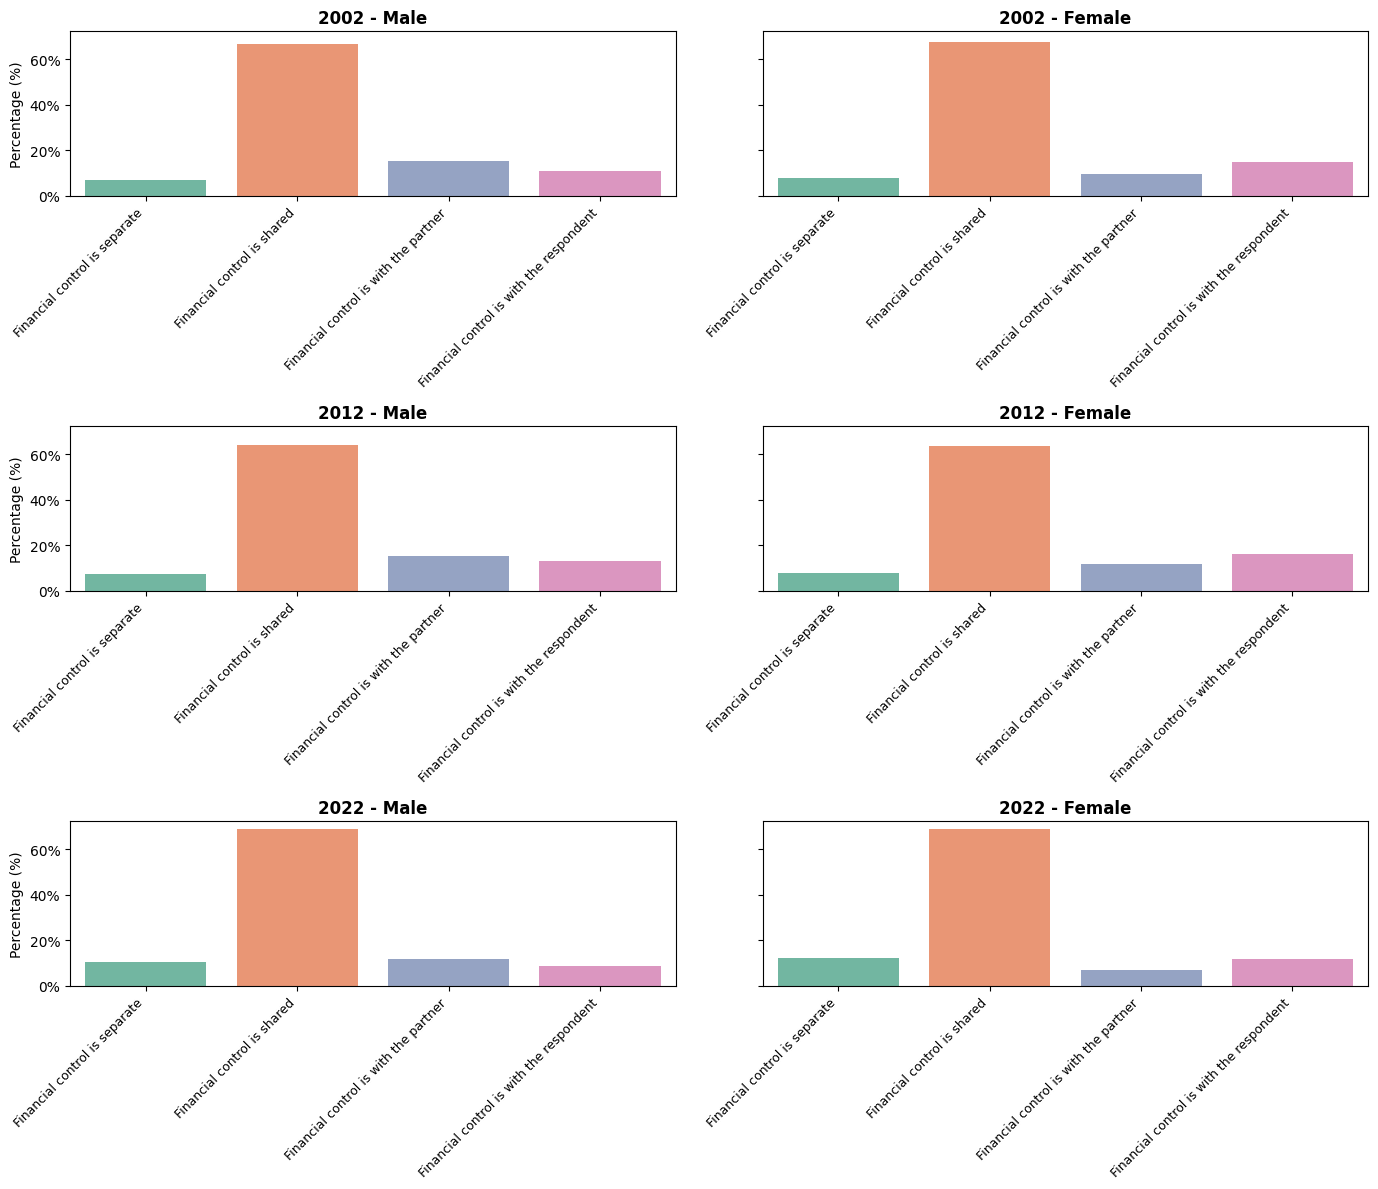

In [192]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharey=True)

years = [2002, 2012, 2022]
dfs = [df_2002, df_2012, df_2022]
sex_labels = ["Male", "Female"]
sex_codes_2022 = ["1. Male", "2. Female"]

for row, (year, df) in enumerate(zip(years, dfs)):
    for col, sex in enumerate(sex_labels):
        ax = axes[row, col]
        
        if year == 2002:
            sub = df[(df["v200"] == sex) & (df["v202"] == "Marr,liv as mar")]
        elif year == 2012:
            sub = df[(df["SEX"] == sex) & (df["MARITAL"] == "Married")]
        else:  # 2022
            sub = df[(df["SEX"] == sex_codes_2022[col]) & (df["MARITAL"] == '1. Married')]
        
        vc = sub["code_income_control"].value_counts(normalize=True) * 100
        vc = vc.sort_index()
        
        sns.barplot(x=vc.index, y=vc.values, ax=ax, palette="Set2")
        ax.set_title(f"{year} - {sex}", fontsize=12, fontweight='bold')
        ax.set_ylabel("Percentage (%)" if col == 0 else "")
        ax.set_xlabel("")
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.show()

In [193]:
def fix_hh_hours(x):
    invalid_options=[
        "Don't know, BG: can't choose",
        'No answer, CA: no answer, refused',
        "Don't know, BG: can't choose, KR: don't know, refused",
        'No answer, CA: no answer, refused',
        'NAP, no partner (3 (AR,AT,BE,CH,CL,ES,IS,KR,NL,NO,PL,SK,US:2,3; BG,CZ,PT:2,3,7;IL:3,7) in PARTLIV;TW:3-6 in MARITAL)',
        "-9. No answer; HR, IS: DK/NA; ES, HU: Can't Ch/NA; LT: NA/DK/Hard to say; PL: Hard to say/NA; TW: Can't choose",
        "-9. No answer; HR, IS: DK/NA; ES, HU, TW: Can't Ch/NA; LT: NA/DK/Hard to say; PL: Hard to say/NA",
       '-4. NAP, no partn. or not liv. with part. (c.2,3,-7 PARTLIV; US: c.2 (if neither married nor cohabit. with partner), 3 PARTL'
                     ]
    if x in invalid_options:
        return None
    if isinstance(x, str):
        x = x.strip()
        if x.startswith("None") or x.startswith("0"):
            return 0
        elif x.startswith("95"):
            return 95
        elif x.startswith("1"):
            return 1
        elif x.startswith("2"):
            return 2
        elif x.startswith("3"):
            return 3
        else:
            return int(x)
    return x


df_2002['v36']=df_2002['v36'].apply(fix_hh_hours)
df_2002['v37']=df_2002['v37'].apply(fix_hh_hours)
df_2002["hh_bin"] = pd.cut(
    df_2002["v36"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0–20", "21–40", "41–60", "61–80", "81+"]
)
df_2002["spouse_hh_bin"] = pd.cut(
    df_2002["v37"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0–20", "21–40", "41–60", "61–80", "81+"]
)

df_2012['V37']=df_2012['V37'].apply(fix_hh_hours)
df_2012['V39']=df_2012['V39'].apply(fix_hh_hours)

df_2012["hh_bin"] = pd.cut(
    df_2012["V37"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0–20", "21–40", "41–60", "61–80", "81+"]
)
df_2012["spouse_hh_bin"] = pd.cut(
    df_2012["V39"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0–20", "21–40", "41–60", "61–80", "81+"]
)

df_2022['v34']=df_2022['v34'].apply(fix_hh_hours)
df_2022['v36']=df_2022['v36'].apply(fix_hh_hours)

df_2022["hh_bin"] = pd.cut(
    df_2022["v34"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0–20", "21–40", "41–60", "61–80", "81+"]
)
df_2022["spouse_hh_bin"] = pd.cut(
    df_2022["v36"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["0–20", "21–40", "41–60", "61–80", "81+"]
)


In [174]:
df_2002[(df_2002["v200"] == "Female") & (df_2002["code_income_control"] == "Financial control is with the respondent")]["v358"].value_counts()

v358
Urban,a big city               595
Town or small city             532
Country village                488
Suburb big city,big town       206
Farm or home in the country     52
Other                            0
Name: count, dtype: int64

In [175]:
df_2002[(df_2002["v200"] == "Male") & (df_2002["code_income_control"] == "Financial control is with the partner")]["v358"].value_counts()

v358
Urban,a big city               517
Town or small city             478
Country village                435
Suburb big city,big town       214
Farm or home in the country     40
Other                            0
Name: count, dtype: int64

In [194]:
df_2002.name = "df_2002"
df_2012.name = "df_2012"
df_2022.name = "df_2022"

In [198]:
years = [2002, 2012, 2022]
dfs = [df_2002, df_2012, df_2022]

results = []

for year, df in zip(years, dfs):
    if year == 2002:
        male = df[(df["v200"] == "Male") & (df["v202"] == "Marr,liv as mar")]
        female = df[(df["v200"] == "Female") & (df["v202"] == "Marr,liv as mar")]
    elif year == 2012:
        male = df[(df["SEX"] == "Male") & (df["MARITAL"] == "Married")]
        female = df[(df["SEX"] == "Female") & (df["MARITAL"] == "Married")]
    else:  # 2022
        male = df[(df["SEX"] == "1. Male") & (df["MARITAL"] == "1. Married")]
        female = df[(df["SEX"] == "2. Female") & (df["MARITAL"] == "1. Married")]
    

    # keep only single-person control
    male_single = male[male["code_income_control"].isin(["Financial control is with the partner", "Financial control is with the respondent"])]
    # print(len(male_single))
    female_single = female[female["code_income_control"].isin(["Financial control is with the partner", "Financial control is with the respondent"])]

    results.append({
        "Year": year,
        "Male share": len(male_single) / (len(male_single) + len(female_single)) * 100,
        "Female share": len(female_single) / (len(male_single) + len(female_single)) * 100
    })

res_df = pd.DataFrame(results)
res_df

,Year,Male share,Female share
0,2002,48.359422,51.640578
1,2012,49.449244,50.550756
2,2022,50.747664,49.252336


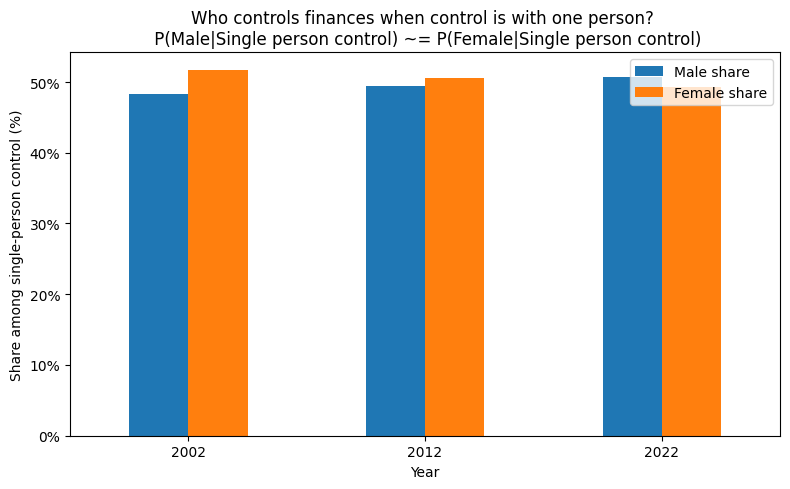

In [201]:
res_df.set_index("Year")[["Male share", "Female share"]].plot(
    kind="bar",
    figsize=(8, 5)
)

plt.ylabel("Share among single-person control (%)")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Who controls finances when control is with one person? \n P(Male|Single person control) ~= P(Female|Single person control)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
